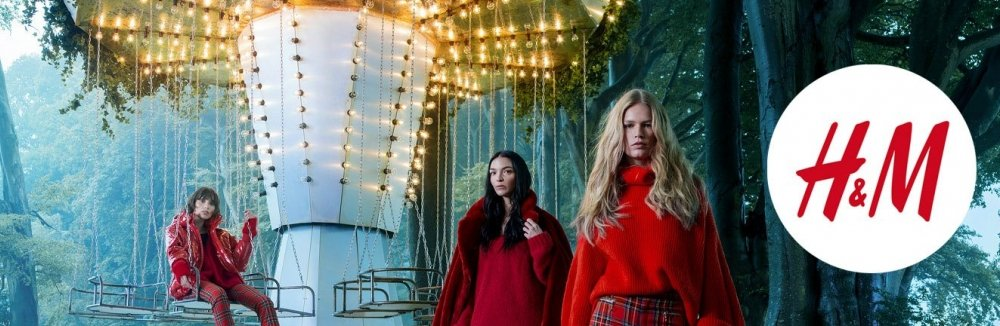

# Data Preparation

In [3]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split
from surprise.prediction_algorithms import SVD, SVDpp, NMF, BaselineOnly, NormalPredictor, KNNBasic

# from sklearn.model_selection import train_test_split

plt.style.use('fast')
%matplotlib inline

In [4]:
# display 50 columns
pd.set_option('display.max_columns', 50)

Read in the `out` file which is the data prepared for the collaborative modeling in the `FinalDataPreparation` notebook.

In [5]:
transactions = pd.read_csv('Data/out.zip')
transactions.head(3)

InvoiceDate                                        customer_id  article_id  \
0  2020-09-14  0008968c0d451dbc5a9968da03196fe20051965edde741...   893059004   
1  2020-09-03  002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...   902802002   
2  2020-09-03  002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...   805000007   

      price  sales_channel_id       t_dat        date  bought  
0  0.035576                 2  2020-09-14  2020-09-14       1  
1  0.033881                 2  2020-09-03  2020-09-03       1  
2  0.050831                 2  2020-09-03  2020-09-03       1

In [7]:
transactions.shape

(671674, 8)

In [8]:
transactions.customer_id[1]

'002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc'

In [9]:
transactions.customer_id[1]

'002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc'

Transactions data description:

- t_dat : A unique identifier of every customer
- customer_id : A unique identifier of every customer (in customers table)
- article_id : A unique identifier of every article (in articles table)
- price : Price of purchase
- sales_channel_id : 1 or 2

### Surprise Data & Split 

In [10]:
# Instantiate reader the same convention as a sklearn class
reader = Reader(rating_scale = (0,1))
# Load user_data from imported dataframe specifiyng which columns to use
customer_data = Dataset.load_from_df(transactions[['customer_id', 'article_id', 'bought']], reader)

In [11]:
type(customer_data)

surprise.dataset.DatasetAutoFolds

In [12]:
# Perform an appropriate split for the recommendation models
trainset, testset = train_test_split(customer_data, test_size=0.2, random_state=42)

In [13]:
#How many users and items are in the trainset
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')

Number of users:  172712 

Number of items:  9225 



## Modeling

### Baselines without cross validation

In [14]:
# Instantiate and fit model
baseline = NormalPredictor()
baseline.fit(trainset)

# Return test predictions for model fit on trainset
predictions = baseline.test(testset)

# Save RMSE score to variable
baseline_normal = accuracy.rmse(predictions)

RMSE: 0.0000


In [15]:
# Instantiate and fit model
baseline2 = BaselineOnly()
baseline2.fit(trainset)

# Return test predictions for model fit on trainset
predictions = baseline2.test(testset)

# Save RMSE score to variable
baseline_only = accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.0000


### SVD

In [16]:
svd_model = SVD()
svd_model.fit(trainset)
svd_predictions = svd_model.test(testset)
svd_simple_predictions = accuracy.rmse(svd_predictions)
svd_simple_predictions

RMSE: 0.0461


0.046148969627165776

In [17]:
svd_model.predict('0008968c0d451dbc5a9968da03196fe20051965edde7413775c4eb3be9abe9c2', 902802002)

Prediction(uid='0008968c0d451dbc5a9968da03196fe20051965edde7413775c4eb3be9abe9c2', iid=902802002, r_ui=None, est=0.9443235496457111, details={'was_impossible': False})

In [18]:
transactions.loc[(transactions['customer_id'] == '0008968c0d451dbc5a9968da03196fe20051965edde7413775c4eb3be9abe9c2') & 
                 (transactions['article_id'] == 902802002)]

Empty DataFrame
Columns: [InvoiceDate, customer_id, article_id, price, sales_channel_id, t_dat, date, bought]
Index: []

In [19]:
param_grid = {'n_factors':[10,50],'n_epochs': [5, 15], 'lr_all': [0.002,0.01],
             'reg_all': [0.2,0.6]}
gs_model_SVD1 = GridSearchCV(SVD,param_grid=param_grid,joblib_verbose=5, measures=['RMSE'], n_jobs=-2)
gs_model_SVD1.fit(customer_data)

gs_model_SVD1.best_params

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 23 concurrent workers.
[Parallel(n_jobs=-2)]: Done  26 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-2)]: Done  52 out of  80 | elapsed:   25.5s remaining:   13.7s
[Parallel(n_jobs=-2)]: Done  69 out of  80 | elapsed:   34.1s remaining:    5.4s
[Parallel(n_jobs=-2)]: Done  80 out of  80 | elapsed:   39.4s finished


{'rmse': {'n_factors': 10, 'n_epochs': 15, 'lr_all': 0.01, 'reg_all': 0.6}}

explain

In [20]:
param_grid2 = {'n_factors':[5,10],'n_epochs': [15, 50], 'lr_all': [0.001, 0.01],
             'reg_all': [0.6, 0.8]}
gs_model_SVD2 = GridSearchCV(SVD,param_grid=param_grid2,joblib_verbose=5, measures=['RMSE'], n_jobs=-2)
gs_model_SVD2.fit(customer_data)

gs_model_SVD2.best_params

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 23 concurrent workers.
[Parallel(n_jobs=-2)]: Done  26 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-2)]: Done  52 out of  80 | elapsed:   26.3s remaining:   14.2s
[Parallel(n_jobs=-2)]: Done  69 out of  80 | elapsed:   35.7s remaining:    5.7s
[Parallel(n_jobs=-2)]: Done  80 out of  80 | elapsed:   41.2s finished


{'rmse': {'n_factors': 5, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.8}}

explain

In [21]:
param_grid3 = {'n_factors':[10],'n_epochs': [50, 100], 'lr_all': [0.1, 0.2],
             'reg_all': [0.8, 0.9]}
gs_model_SVD3 = GridSearchCV(SVD,param_grid=param_grid3,joblib_verbose=5, measures=['RMSE'], n_jobs=-2)
gs_model_SVD3.fit(customer_data)

gs_model_SVD3.best_params

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 23 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 out of  40 | elapsed:    4.2s remaining:   38.0s
[Parallel(n_jobs=-2)]: Done  13 out of  40 | elapsed:    8.8s remaining:   18.2s
[Parallel(n_jobs=-2)]: Done  22 out of  40 | elapsed:   15.3s remaining:   12.5s
[Parallel(n_jobs=-2)]: Done  31 out of  40 | elapsed:   22.3s remaining:    6.5s
[Parallel(n_jobs=-2)]: Done  40 out of  40 | elapsed:   29.3s finished


{'rmse': {'n_factors': 10, 'n_epochs': 100, 'lr_all': 0.2, 'reg_all': 0.9}}

In [22]:
param_grid4 = {'n_factors':[10],'n_epochs': [100, 150], 'lr_all': [0.2, 0.3],
             'reg_all': [0.7, 0.8]}
gs_model_SVD4 = GridSearchCV(SVD,param_grid=param_grid4,joblib_verbose=5, measures=['RMSE'], n_jobs=-2)
gs_model_SVD4.fit(customer_data)

gs_model_SVD4.best_params

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 23 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 out of  40 | elapsed:    6.5s remaining:   58.4s
[Parallel(n_jobs=-2)]: Done  13 out of  40 | elapsed:   21.0s remaining:   43.6s
[Parallel(n_jobs=-2)]: Done  22 out of  40 | elapsed:   41.3s remaining:   33.8s
[Parallel(n_jobs=-2)]: Done  31 out of  40 | elapsed:   57.4s remaining:   16.7s
[Parallel(n_jobs=-2)]: Done  40 out of  40 | elapsed:  1.1min finished


{'rmse': {'n_factors': 10, 'n_epochs': 100, 'lr_all': 0.2, 'reg_all': 0.8}}

We find the best parameters for SVD modeling are - 
- n_factors : 10
- n_epochs : 100
- lr_all :0.2
- reg_all : 0.8

Now we build a model with the best parameters and test it on our testset.

In [24]:
svd_model2 = SVD(n_factors= 10, n_epochs= 100)
svd_model2.fit(trainset)
svd_predictions2 = svd_model2.test(testset)
svd_tuned_predictions = accuracy.rmse(svd_predictions2)
svd_tuned_predictions

RMSE: 0.0090


0.009004070437950904

### NFM 

Now, we explore the `Non-negative Matrix Factorization (NMF)` from the `suprise` library. The only difference between this algorithm and the previous algorithm SVD is that in NMF, a specific step size is set for the stochastic gradient descent process of regularization. This is done to ensure that all user and item factors are kept positive. While this model can be prone to over-fitting, this can be mitigated with steps to reduce the dimensionality of our data/factors.

In [25]:
nmf_model = NMF()
nmf_model.fit(trainset)
nmf_predictions = nmf_model.test(testset)
nmf_simple_predictions = accuracy.rmse(nmf_predictions)
nmf_simple_predictions

RMSE: 0.0678


0.06780810821295505

In [26]:
param_grid = {'n_factors':[10,15,20],'n_epochs': [25, 50, 75]}
gs_model_NFM = GridSearchCV(NMF,param_grid=param_grid,joblib_verbose=5, measures=['RMSE'], n_jobs=-2)
gs_model_NFM.fit(customer_data)

gs_model_NFM.best_params

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 23 concurrent workers.
[Parallel(n_jobs=-2)]: Done  10 out of  45 | elapsed:   11.7s remaining:   40.8s
[Parallel(n_jobs=-2)]: Done  20 out of  45 | elapsed:   21.8s remaining:   27.2s
[Parallel(n_jobs=-2)]: Done  30 out of  45 | elapsed:   29.7s remaining:   14.8s
[Parallel(n_jobs=-2)]: Done  40 out of  45 | elapsed:   40.6s remaining:    5.1s
[Parallel(n_jobs=-2)]: Done  45 out of  45 | elapsed:   44.1s finished


{'rmse': {'n_factors': 10, 'n_epochs': 75}}

explain

In [27]:
param_grid = {'n_factors':[10],'n_epochs': [75, 100]}
gs_model_NFM2 = GridSearchCV(NMF,param_grid=param_grid,joblib_verbose=5, measures=['RMSE'], n_jobs=-2)
gs_model_NFM2.fit(customer_data)

gs_model_NFM2.best_params

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 23 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 out of  10 | elapsed:   10.3s remaining:   15.4s
[Parallel(n_jobs=-2)]: Done   7 out of  10 | elapsed:   13.6s remaining:    5.8s
[Parallel(n_jobs=-2)]: Done  10 out of  10 | elapsed:   16.3s finished


{'rmse': {'n_factors': 10, 'n_epochs': 100}}

Explain

We find the best parameters for NMF modeling are - 
- n_factors : 10
- n_epochs : 100

Now we build a model with the best parameters and test it on our testset.

In [28]:
nmf_model2 = NMF(n_factors = 10, n_epochs = 100)
nmf_model2.fit(trainset)
nmf_predictions2 = nmf_model2.test(testset)
nmf_tuned_predictions = accuracy.rmse(nmf_predictions2)

nmf_tuned_predictions

RMSE: 0.0583


0.058254719274244415

## SVD ++ 

For a final look at models from the `surprise` library, I wanted to try and utilize the SVD++ algorithm, again, very similar to SVD. The difference is that SVD++ attempts to add an extension onto the base SVD that uses implicit rating as well as explicit. In other words it infers the action of rating an item as a latent factor regardless of the rating value given to the item while also factoring the actual rating value. I thought this might further improve the RMSE by taking into account reviewers who have rated a large number of eBooks. Please note that this Grid Search will take a very long time to run.

In [29]:
# Instantiate - fit on trainset - score the model on testset
SVDpp_model = SVDpp()
SVDpp_model.fit(trainset)
SVDpp_predictions = SVDpp_model.test(testset)
svdpp_simple_predictions = accuracy.rmse(SVDpp_predictions)

svdpp_simple_predictions

RMSE: 0.0208


0.02083709511988084

In [30]:
# New dictionary for SVD++
svdpp_param_grid = {'n_factors':[1, 5], 'n_epochs':[25, 50], 'reg_all':[0.02, 0.05]}
svdpp_gs_model = GridSearchCV(SVDpp, param_grid=svdpp_param_grid, cv=3, joblib_verbose=5, n_jobs=-2, measures=['RMSE'])

# Fit and return the best_params based on cross validation this will take a VERY long time to run
svdpp_gs_model.fit(customer_data)

svdpp_gs_model.best_params

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 23 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 out of  24 | elapsed:    5.4s remaining:   26.8s
[Parallel(n_jobs=-2)]: Done   9 out of  24 | elapsed:    8.9s remaining:   14.9s
[Parallel(n_jobs=-2)]: Done  14 out of  24 | elapsed:   10.4s remaining:    7.5s
[Parallel(n_jobs=-2)]: Done  19 out of  24 | elapsed:   14.4s remaining:    3.8s
[Parallel(n_jobs=-2)]: Done  24 out of  24 | elapsed:   16.9s finished


{'rmse': {'n_factors': 1, 'n_epochs': 50, 'reg_all': 0.05}}

explain

In [ ]:
# New dictionary for SVD++
svdpp_param_grid2 = {'n_factors':[1], 'n_epochs':[50, 100], 'reg_all':[0.05, 0.1]}
svdpp_gs_model2 = GridSearchCV(SVDpp, param_grid=svdpp_param_grid2, cv=3, joblib_verbose=5, n_jobs=-2, measures=['RMSE'])

# Fit and return the best_params based on cross validation this will take a VERY long time to run
svdpp_gs_model2.fit(customer_data)

svdpp_gs_model2.best_params

We find the best parameters for SVD ++ modeling are - 
- n_factors : 1
- n_epochs : 100
- reg_all : 0.1

Now we build a model with the best parameters and test it on our testset.

In [31]:
# Instantiate - fit on trainset - score the model on testset
SVDpp_model2 = SVDpp(n_factors=1, n_epochs=100, reg_all=0.1)
SVDpp_model2.fit(trainset)
SVDpp_predictions2 = SVDpp_model2.test(testset)
svdpp_tuned_predictions = accuracy.rmse(SVDpp_predictions2)

svdpp_tuned_predictions

RMSE: 0.0008


0.0008330104375928024

## Model Performance

In [32]:
# # just to code ahead! 
baseline_only = 0.00
svd_simple_predictions = 0.0463
svd_tuned_predictions = 0.0115
nmf_simple_predictions = 0.0676
nmf_tuned_predictions = 0.0582
svdpp_simple_predictions = 0.0206
svdpp_tuned_predictions = 0.0207

In [33]:
X = ['Baseline', 'SVD Basic', 'SVD Tuned', 'NMF Basic', 'NMF tuned', 'SVD ++ Basic', 'SVD ++ Tuned']
y = [baseline_only, svd_simple_predictions, svd_tuned_predictions, nmf_simple_predictions, nmf_tuned_predictions, svdpp_simple_predictions, svdpp_tuned_predictions]

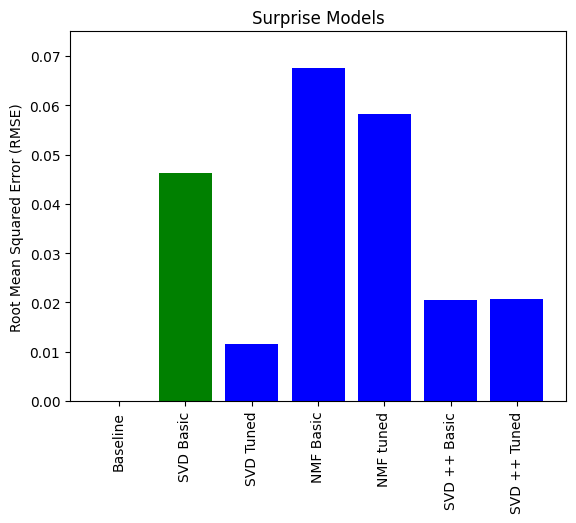

In [34]:
fig, ax = plt.subplots()
plt.bar(X, y, color=['black', 'green', 'blue', 'blue', 'blue', 'blue', 'blue'])
plt.xticks(rotation=90)
plt.ylim(0, .075)
plt.grid(False)
ax.set_title("Surprise Models")
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.savefig('Images/Model_bar.png', dpi=500, bbox_inches='tight');

# Recommendation Function

### Building

##### Final Model

In [35]:
# Using Surprise a full trainset incorporating all data can be built and fit to the model in order to make full predictions
trainset_full = customer_data.build_full_trainset()

In [37]:
final_model = SVD(n_factors= 10, n_epochs= 100)
final_model.fit(trainset_full)

In [38]:
# The model is pickled and saved into the Model folder in the repository so it can used in the app.py file
pickle.dump(final_model, open('Model/collaborative_model.sav', 'wb'))

In [39]:
collab_model = pickle.load(open('Model/collaborative_model.sav', 'rb'))

In [40]:
transactions.tail(10)

InvoiceDate                                        customer_id  \
671664  2020-09-22  ff732b98019465f078144bae647d7d9765d76e3431ef92...   
671665  2020-09-22  ff732b98019465f078144bae647d7d9765d76e3431ef92...   
671666  2020-09-22  ff732b98019465f078144bae647d7d9765d76e3431ef92...   
671667  2020-09-22  ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3...   
671668  2020-09-22  ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3...   
671669  2020-09-22  ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3...   
671670  2020-09-22  ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3...   
671671  2020-09-22  ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3...   
671672  2020-09-22  ffc92c3f7b0b302f393c2968b290f6e5c5b5510d1cf1df...   
671673  2020-09-22  ffc92c3f7b0b302f393c2968b290f6e5c5b5510d1cf1df...   

        article_id     price  sales_channel_id       t_dat        date  bought  
671664   651591001  0.032186                 2  2020-09-22  2020-09-22       1  
671665   864339003  0.022017                 2  2020-09-22  2020-09-22       1  
671666   938667001  0.010153                 2  2020-09-22  2020-09-22       1  
671667   762846006  0.025407                 2  2020-09-22  2020-09-22       1  
671668   762846027  0.025407                 2  2020-09-22  2020-09-22       1  
671669   914404001  0.042356                 2  2020-09-22  2020-09-22       1  
671670   751471041  0.033881                 2  2020-09-22  2020-09-22       1  
671671   751471038  0.033881                 2  2020-09-22  2020-09-22       1  
671672   895730002  0.045746                 2  2020-09-22  2020-09-22       1  
671673   740519002  0.045746                 2  2020-09-22  2020-09-22       1

Start from here... 
- we have to load the articles df here as meta data with article id as the index 
- build function

In [41]:
# Load in the meta data for use in returning the details about the recommended articles 
meta_articles = pd.read_csv('Data/articles.csv.zip', index_col='article_id')
meta_articles.head(3)

product_code      prod_name  product_type_no product_type_name  \
article_id                                                                   
108775015         108775      Strap top              253          Vest top   
108775044         108775      Strap top              253          Vest top   
108775051         108775  Strap top (1)              253          Vest top   

            product_group_name  graphical_appearance_no  \
article_id                                                
108775015   Garment Upper body                  1010016   
108775044   Garment Upper body                  1010016   
108775051   Garment Upper body                  1010017   

           graphical_appearance_name  colour_group_code colour_group_name  \
article_id                                                                  
108775015                      Solid                  9             Black   
108775044                      Solid                 10             White   
108775051                     Stripe                 11         Off White   

            perceived_colour_value_id perceived_colour_value_name  \
article_id                                                          
108775015                           4                        Dark   
108775044                           3                       Light   
108775051                           1                 Dusty Light   

            perceived_colour_master_id perceived_colour_master_name  \
article_id                                                            
108775015                            5                        Black   
108775044                            9                        White   
108775051                            9                        White   

            department_no department_name index_code  index_name  \
article_id                                                         
108775015            1676    Jersey Basic          A  Ladieswear   
108775044            1676    Jersey Basic          A  Ladieswear   
108775051            1676    Jersey Basic          A  Ladieswear   

            index_group_no index_group_name  section_no  \
article_id                                                
108775015                1       Ladieswear          16   
108775044                1       Ladieswear          16   
108775051                1       Ladieswear          16   

                      section_name  garment_group_no garment_group_name  \
article_id                                                                
108775015   Womens Everyday Basics              1002       Jersey Basic   
108775044   Womens Everyday Basics              1002       Jersey Basic   
108775051   Womens Everyday Basics              1002       Jersey Basic   

                                        detail_desc  
article_id                                           
108775015   Jersey top with narrow shoulder straps.  
108775044   Jersey top with narrow shoulder straps.  
108775051   Jersey top with narrow shoulder straps.

In [42]:
# sanity check
meta_articles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105542 entries, 108775015 to 959461001
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   product_code                  105542 non-null  int64 
 1   prod_name                     105542 non-null  object
 2   product_type_no               105542 non-null  int64 
 3   product_type_name             105542 non-null  object
 4   product_group_name            105542 non-null  object
 5   graphical_appearance_no       105542 non-null  int64 
 6   graphical_appearance_name     105542 non-null  object
 7   colour_group_code             105542 non-null  int64 
 8   colour_group_name             105542 non-null  object
 9   perceived_colour_value_id     105542 non-null  int64 
 10  perceived_colour_value_name   105542 non-null  object
 11  perceived_colour_master_id    105542 non-null  int64 
 12  perceived_colour_master_name  105542 non-null  objec

In [43]:
transactions.head()

InvoiceDate                                        customer_id  article_id  \
0  2020-09-14  0008968c0d451dbc5a9968da03196fe20051965edde741...   893059004   
1  2020-09-03  002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...   902802002   
2  2020-09-03  002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...   805000007   
3  2020-09-03  002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...   918292001   
4  2020-09-03  002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...   805000001   

      price  sales_channel_id       t_dat        date  bought  
0  0.035576                 2  2020-09-14  2020-09-14       1  
1  0.033881                 2  2020-09-03  2020-09-03       1  
2  0.050831                 2  2020-09-03  2020-09-03       1  
3  0.042356                 2  2020-09-03  2020-09-03       1  
4  0.050831                 2  2020-09-03  2020-09-03       1

In [44]:
# The transactions data is subset to just show customers and the articles they have bought
df_customer = transactions.set_index('customer_id')
df_customer.drop(columns=['InvoiceDate', 'price', 'sales_channel_id', 't_dat', 'date', 'bought'], inplace=True)
df_customer.head()

article_id
customer_id                                                   
0008968c0d451dbc5a9968da03196fe20051965edde7413...   893059004
002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab...   902802002
002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab...   805000007
002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab...   918292001
002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab...   805000001

In [45]:
# Save the `df_customer` as a new csv

df_customer.to_csv('Data/df_customer.csv')

In [46]:
pd.read_csv('Data/df_customer.csv', index_col='customer_id')

article_id
customer_id                                                   
0008968c0d451dbc5a9968da03196fe20051965edde7413...   893059004
002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab...   902802002
002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab...   805000007
002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab...   918292001
002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab...   805000001
...                                                        ...
ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a37...   914404001
ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a37...   751471041
ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a37...   751471038
ffc92c3f7b0b302f393c2968b290f6e5c5b5510d1cf1dfd...   895730002
ffc92c3f7b0b302f393c2968b290f6e5c5b5510d1cf1dfd...   740519002

[671674 rows x 1 columns]

In [52]:
# Dual input for unique customer ID and how many recommendations you would like
customer = input('CustomerID: ')
n_recs = int(input('How many recommendations? '))

In [53]:
# Creating a list of the eBooks that said reviewer has already rated 
have_bought = list(df_customer.loc[customer, 'article_id'])
# add
have_bought = df_customer.loc[customer, 'article_id'].tolist()
have_bought

[902802002, 805000007, 918292001, 805000001, 730683050, 910824001]

In [54]:
# Creating new dataframe from meta data to subset based on already bought articles
not_bought = meta_articles.copy()
# Dropping indexes (article_id) that correspond to already bought articles
not_bought.drop(have_bought, inplace=True)
# Reset index to pull out article_id as a seperate column
not_bought.reset_index(inplace=True)
not_bought.head(3)

article_id  product_code      prod_name  product_type_no product_type_name  \
0   108775015        108775      Strap top              253          Vest top   
1   108775044        108775      Strap top              253          Vest top   
2   108775051        108775  Strap top (1)              253          Vest top   

   product_group_name  graphical_appearance_no graphical_appearance_name  \
0  Garment Upper body                  1010016                     Solid   
1  Garment Upper body                  1010016                     Solid   
2  Garment Upper body                  1010017                    Stripe   

   colour_group_code colour_group_name  perceived_colour_value_id  \
0                  9             Black                          4   
1                 10             White                          3   
2                 11         Off White                          1   

  perceived_colour_value_name  perceived_colour_master_id  \
0                        Dark                           5   
1                       Light                           9   
2                 Dusty Light                           9   

  perceived_colour_master_name  department_no department_name index_code  \
0                        Black           1676    Jersey Basic          A   
1                        White           1676    Jersey Basic          A   
2                        White           1676    Jersey Basic          A   

   index_name  index_group_no index_group_name  section_no  \
0  Ladieswear               1       Ladieswear          16   
1  Ladieswear               1       Ladieswear          16   
2  Ladieswear               1       Ladieswear          16   

             section_name  garment_group_no garment_group_name  \
0  Womens Everyday Basics              1002       Jersey Basic   
1  Womens Everyday Basics              1002       Jersey Basic   
2  Womens Everyday Basics              1002       Jersey Basic   

                               detail_desc  
0  Jersey top with narrow shoulder straps.  
1  Jersey top with narrow shoulder straps.  
2  Jersey top with narrow shoulder straps.

In [55]:
# Obtain rating predictions based on model.predict, passing in user input. 
# Using .apply with lamdba function to iterate through
not_bought['est_purchase'] = not_bought['article_id'].apply(lambda x: final_model.predict(customer, x).est)
# Sort dataframe based on newly created est_purchase problem in order to return top estimated ratings (purcahse in this case)
not_bought.sort_values(by='est_purchase', ascending=False, inplace=True)
not_bought.head()

article_id  product_code                       prod_name  \
56969   715343007        715343  Lazer Razer Roundneck swimsuit   
99375   884174002        884174               SPEED Ellinor top   
85042   817777001        817777         ED Long leggings 2-pack   
99382   884220001        884220                       Rey skirt   
99384   884236001        884236          AK Maru jumpsuit Short   

       product_type_no  product_type_name  product_group_name  \
56969               57           Swimsuit            Swimwear   
99375              254                Top  Garment Upper body   
85042              273    Leggings/Tights  Garment Lower body   
99382              275              Skirt  Garment Lower body   
99384              267  Jumpsuit/Playsuit   Garment Full body   

       graphical_appearance_no graphical_appearance_name  colour_group_code  \
56969                  1010016                     Solid                 93   
99375                  1010016                     Solid                 83   
85042                  1010016                     Solid                  9   
99382                  1010001          All over pattern                 73   
99384                  1010016                     Solid                 13   

      colour_group_name  perceived_colour_value_id  \
56969        Dark Green                          2   
99375    Dark Turquoise                          4   
85042             Black                          4   
99382         Dark Blue                          4   
99384             Beige                          1   

      perceived_colour_value_name  perceived_colour_master_id  \
56969                Medium Dusty                          19   
99375                        Dark                           7   
85042                        Dark                           5   
99382                        Dark                           2   
99384                 Dusty Light                           1   

      perceived_colour_master_name  department_no       department_name  \
56969                        Green           4242              Swimwear   
99375                    Turquoise           1666                Jersey   
85042                        Black           1919                Jersey   
99382                         Blue           1414                 Skirt   
99384                         Mole           5626  AK Dresses & Outdoor   

      index_code        index_name  index_group_no index_group_name  \
56969          B  Lingeries/Tights               1       Ladieswear   
99375          A        Ladieswear               1       Ladieswear   
85042          A        Ladieswear               1       Ladieswear   
99382          A        Ladieswear               1       Ladieswear   
99384          D           Divided               2          Divided   

       section_no                section_name  garment_group_no  \
56969          60  Womens Swimwear, beachwear              1018   
99375          11            Womens Tailoring              1005   
85042           2                        H&M+              1005   
99382          11            Womens Tailoring              1012   
99384          70           Divided Asia keys              1013   

      garment_group_name                                        detail_desc  \
56969           Swimwear  Fully lined swimsuit with narrow, adjustable s...   
99375       Jersey Fancy  Sleeveless top in jersey crêpe with a double-l...   
85042       Jersey Fancy  Leggings in jersey with an elasticated waist. ...   
99382             Skirts  Knee-length skirt in an airy, patterned weave ...   
99384     Dresses Ladies  Straight-cut playsuit in a cotton crêpe weave ...   

       est_purchase  
56969           1.0  
99375           1.0  
85042           1.0  
99382           1.0  
99384           1.0

In [56]:
not_bought['est_purchase'].tail()

82466     0.905437
98250     0.902743
88124     0.898915
97351     0.895637
102771    0.878087
Name: est_purchase, dtype: float64

In [57]:
# Captilizing column names for a more appealing final display
not_bought.rename(columns={'prod_name':'Product Name', 'author':'Author',
                               'product_type_name':'Product Type Name', 'product_group_name':'Product Group Name',
                               'index_group_name':'Index Group Name', 'garment_group_name ':'Garment Group Name'}, inplace=True)

In [58]:
# Final step is to only return the top n_recs as denoted by input, done using .head(n_recs)
not_bought.head(n_recs)

article_id  product_code                    Product Name  \
56969   715343007        715343  Lazer Razer Roundneck swimsuit   
99375   884174002        884174               SPEED Ellinor top   
85042   817777001        817777         ED Long leggings 2-pack   
99382   884220001        884220                       Rey skirt   
99384   884236001        884236          AK Maru jumpsuit Short   
54680   708311023        708311        vermont fancy slacks (1)   
54679   708311021        708311        vermont fancy slacks (1)   
99398   884319008        884319                Lucien CONSCIOUS   
12317   552716012        552716                  Suzuki shopper   
47691   689389048        689389                DENISE SHIRT S.1   

       product_type_no  Product Type Name  Product Group Name  \
56969               57           Swimsuit            Swimwear   
99375              254                Top  Garment Upper body   
85042              273    Leggings/Tights  Garment Lower body   
99382              275              Skirt  Garment Lower body   
99384              267  Jumpsuit/Playsuit   Garment Full body   
54680              272           Trousers  Garment Lower body   
54679              272           Trousers  Garment Lower body   
99398              258             Blouse  Garment Upper body   
12317               66                Bag         Accessories   
47691              259              Shirt  Garment Upper body   

       graphical_appearance_no graphical_appearance_name  colour_group_code  \
56969                  1010016                     Solid                 93   
99375                  1010016                     Solid                 83   
85042                  1010016                     Solid                  9   
99382                  1010001          All over pattern                 73   
99384                  1010016                     Solid                 13   
54680                  1010004                     Check                 92   
54679                  1010016                     Solid                  7   
99398                  1010001          All over pattern                 33   
12317                  1010026           Other structure                  9   
47691                  1010016                     Solid                 10   

      colour_group_name  perceived_colour_value_id  \
56969        Dark Green                          2   
99375    Dark Turquoise                          4   
85042             Black                          4   
99382         Dark Blue                          4   
99384             Beige                          1   
54680             Green                          1   
54679              Grey                          2   
99398       Dark Orange                          7   
12317             Black                          4   
47691             White                          3   

      perceived_colour_value_name  perceived_colour_master_id  \
56969                Medium Dusty                          19   
99375                        Dark                           7   
85042                        Dark                           5   
99382                        Dark                           2   
99384                 Dusty Light                           1   
54680                 Dusty Light                          20   
54679                Medium Dusty                          12   
99398                      Medium                           3   
12317                        Dark                           5   
47691                       Light                           9   

      perceived_colour_master_name  department_no       department_name  \
56969                        Green           4242              Swimwear   
99375                    Turquoise           1666                Jersey   
85042                        Black           1919                Jersey   
99382                         Blue           1414                 Skirt 

## Function

In [59]:
def customer_article_recommend():
    
    user = input('CustomerID: ')
    n_recs = int(input('How many recommendations? '))
    
    have_bought = list(df_customer.loc[customer, 'article_id'])
    not_bought = meta_articles.copy()
    not_bought.drop(have_bought, inplace=True)
    not_bought.reset_index(inplace=True)
    not_bought['est_purchase'] = not_bought['article_id'].apply(lambda x: final_model.predict(customer, x).est)
    not_bought.sort_values(by='est_purchase', ascending=False, inplace=True)
    
    not_bought.rename(columns={'prod_name':'Product Name','product_type_name':'Product Type Name', 'product_group_name':'Product Group Name',
                               'index_group_name':'Index Group Name', 'garment_group_name':'Garment Group Name'}, inplace=True)
    not_bought = not_bought[['article_id','Product Name', 'Product Type Name', 'Product Group Name', 'Index Group Name', 'Garment Group Name']]
    not_bought.iloc[:100, :]
    not_bought = not_bought.sample(frac=1).reset_index(drop=True)
    return not_bought.head(n_recs)

## Evaluation

In [60]:
example = customer_article_recommend()

example

article_id    Product Name Product Type Name  Product Group Name  \
0   763484001     Harvey hood           Sweater  Garment Upper body   
1   628331007      HARLEY 2 p           T-shirt  Garment Upper body   
2   700946004  LEO HOOD 14.99            Hoodie  Garment Upper body   
3   784461001       Bo Runner        Other shoe               Shoes   
4   502718001      Mist parka            Jacket  Garment Upper body   

  Index Group Name Garment Group Name  
0         Menswear           Knitwear  
1    Baby/Children       Jersey Basic  
2          Divided       Jersey Fancy  
3         Menswear              Shoes  
4          Divided            Outdoor

In [68]:
example.to_csv('Data/example.csv', index=False) 